
#Regulatory Compliance Monitoring

###Presented by Shankha Mullick 1916129


# Project Overview
This project employs a robust pipeline for compliance/ document processing and updation.
It begins by extracting text and layout, segmenting the document into paragraph blocks. The text is transformed into vector embeddings and stored, along with layout metadata, in a database for quick retrieval. The next phase implements a Retrieval-Augmented Generation-based chain of thought pipeline to handle document changelogs . The pipeline automatically fetches pertinent paragraph blocks and layout details which needs to be chaninged from the vector database, generates the updated blocks based on changelogs, and combines changed and unchanged blocks to create a new version of the compliance document.



\

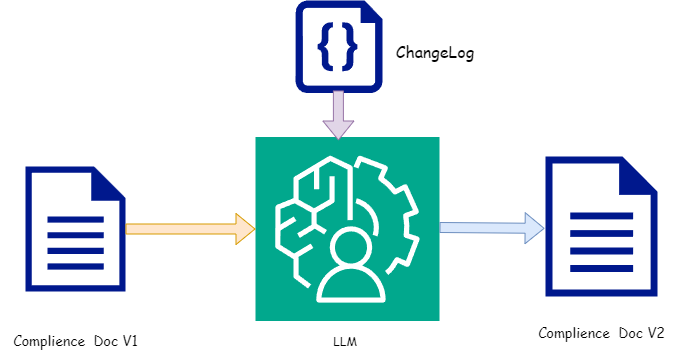


####Installing the required libraries

In [1]:
%pip install --upgrade pymupdf
%pip install tiktoken
%pip install sentence_transformers
%pip install pinecone-client==2.2.2
%pip install langchain
%pip install openai
%pip install pypdf
%pip install reportlab
%pip install anyascii
%pip install ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=aba665b358e686d18af948ed57680166deeb00f8bcccb4de716ca232de14facf
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97

In [2]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')# create the length functiondef

def tiktoken_len(text):

 tokens = tokenizer.encode(text,disallowed_special=())

 return len(tokens)

## Document Preprocessing and Vector DB Ingestion

The initial phase focuses on extracting text and layout information from the compliance document. The document is then segmented into distinct paragraph blocks generate the embeddings and ingest the {embeddings,paragraph text,metadata} into vector DB.

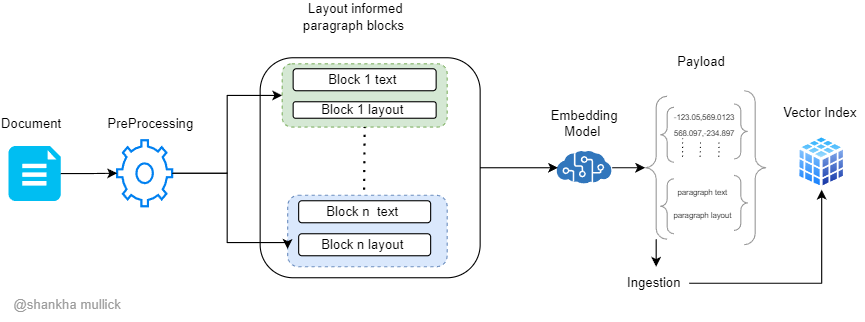

### PDF Text and Layout Extraction with Formatting

The provided Python code utilizes the PyMuPDF library to extract text from a PDF file along with formatting information such as font size, color, and face. The extracted data is organized by page and paragraph block, We will apply the LLM transformations in these blocks based on the changelog and assemble at the end to recreate the PDF with the same layout


In [3]:
import fitz  # PyMuPDF

def extract_text_with_formatting(pdf_path):
    doc = fitz.open(pdf_path)

    result = []

    for page_num in range(doc.page_count):
        page = doc[page_num]
        text_dict = page.get_text('dict')
        blocknum=1
        for block in text_dict['blocks']:

            block_text = ""
            block_formatting = {}

            for line in block.get('lines', []):
                for span in line.get('spans', []):
                    block_text += span.get('text', '')
                    font_size = span.get('size', 0)
                    font_color = span.get('color', 0)
                    font_face = span.get('font', '')

                    #  storing size, color, and face in a dictionary
                    formatting_info = {
                        'size': font_size,
                        'color': font_color,
                        'face': font_face
                    }


                    # Merge formatting information for the entire block
                    block_formatting.update(formatting_info)

                # Add a newline character to separate lines within a block
                block_text += '\n'

            # Remove the trailing newline character
            block_text = block_text.rstrip('\n')

            # Append the extracted block text and formatting to the result list
            result.append({
                'block_number':f'page{page_num+1}_block{blocknum}',
                'block_text': block_text,
                'block_formatting': block_formatting
            })
            blocknum+=1

    doc.close()
    return result




In [5]:
# call extraction function
pdf_path = "/content/css_guidelines_jan_2015.pdf"
extracted_blocks = extract_text_with_formatting(pdf_path)

# Print the result for demonstration
for entry in extracted_blocks:
    print(entry)


{'block_number': 'page1_block1', 'block_text': 'Guidelines ', 'block_formatting': {'size': 12.0, 'color': 0, 'face': 'Verdana,Bold'}}
{'block_number': 'page1_block2', 'block_text': "1.1 These guidelines relate to Standard Condition 19A of the Gas and Electricity \nSupply Licences and Standard Condition 16B of the Electricity Generation Licences \n(collectively referred to as 'the Conditions' for the purposes of these guidelines).  ", 'block_formatting': {'size': 9.960000038146973, 'color': 0, 'face': 'Verdana'}}
{'block_number': 'page1_block3', 'block_text': "1.2. The guidelines have been prepared by the Office of Gas and Electricity Markets \n('Ofgem') pursuant to paragraph 9/19A.9 of the Conditions (throughout this \ndocument the first paragraph number relates to the generation licence and the \nsecond relates to the supply licences).  \n \nScope and Application of the Licence Condition  \n1.3. The Conditions only apply to those companies that are “Relevant Licensees” as \ndefined in

###Create Payload for Vector Db ingestion

The provided Python code snippet utilizes the `tqdm` library for progress tracking and `hashlib.md5` for generating unique identifiers. It processes a collection of extracted blocks, assigning a unique identifier to each block based on its block number. The code then creates records containing the block's ID, text, and metadata.


In [7]:
from sentence_transformers import SentenceTransformer

# We will use embeddings from this model to apply to our data
embedding_model_local = SentenceTransformer(
    "all-MiniLM-L6-v2",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [8]:
from tqdm.auto import tqdm
import hashlib
m = hashlib.md5()
records=[]
index=1
for blocks in tqdm(extracted_blocks):
  block_chunk_name = blocks.get('block_number')
  m.update(block_chunk_name.encode('utf-8'))
  uid = m.hexdigest()[:12]
  id=f'{uid}-{index}'
  metadata={"block_name":block_chunk_name,"block_text":blocks.get('block_text')}
  embedding=embedding_model_local.encode(blocks.get('block_text')).tolist()
  records.append((id,embedding,metadata))
  index+=1


  0%|          | 0/10 [00:00<?, ?it/s]

###Vector Db ingestion


In [15]:
import os
from google.colab import userdata
import pinecone


os.environ["PINECONE_API_KEY"] = userdata.get('PINECONE_API_KEY')
os.environ["PINECONE_ENV"] = userdata.get('PINECONE_ENV')

pinecone_api_key = os.environ["PINECONE_API_KEY"]
pinecone_env = os.environ["PINECONE_ENV"]

pinecone.init(api_key=pinecone_api_key, environment=pinecone_env)

In [16]:

#import pinecone
pinecone_index_name = "ofgem-complience"
#delete index if exists
if pinecone_index_name in pinecone.list_indexes():
    pinecone.delete_index(pinecone_index_name)

In [17]:
# only create index if it doesn't exist
if pinecone_index_name not in pinecone.list_indexes():
    pinecone.create_index(
        name=pinecone_index_name,
        dimension=embedding_model_local.get_sentence_embedding_dimension(),
        metric="cosine",
    )

# connect to the index
pinecone_index = pinecone.Index(pinecone_index_name)

In [18]:
from tqdm.auto import tqdm

batch_size = 1

for i in tqdm(range(0, len(records), batch_size)):
    # find end of batch
    i_end = min(i + batch_size, len(records))
    print(records[i:i_end])
    pinecone_index.upsert(vectors=records[i:i_end])

# check number of records in the index
pinecone_index.describe_index_stats()

  0%|          | 0/10 [00:00<?, ?it/s]

[('52e05e7000d8-1', [-0.02438652701675892, 0.03392883390188217, -0.051013436168432236, -0.042523425072431564, -0.039311524480581284, 0.03127181529998779, -0.00019822196918539703, 0.04131366312503815, -0.12547945976257324, -0.04044286534190178, 0.03594542667269707, 0.013137705624103546, -0.018868325278162956, 0.03519658371806145, -0.0131278270855546, -0.019820310175418854, 0.05783414468169212, -0.04550684988498688, -0.09571705013513565, -0.03688615933060646, 0.09142957627773285, 0.01743592508137226, 0.008764566853642464, -0.01965366117656231, -0.08177574723958969, -0.015271799638867378, 0.005722868721932173, 0.015519835986196995, 0.00890829972922802, -0.02987934648990631, -0.00020481616957113147, -0.029773203656077385, 0.04725579544901848, -0.01649087481200695, -0.05435545742511749, 0.03831201419234276, 0.07389400899410248, 0.011128288693726063, -0.03402956947684288, 0.011636746115982533, -0.02322380058467388, -0.0402066707611084, -0.06170811131596565, 0.023649228736758232, 0.0609650425

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [19]:
query = """pdated:\n[Section 1.6 - Exceptional Items]\na. Added sub-section 1.6.1 - Unforeseen Legal Expenses:\nUnforeseen legal expenses that were not part of the regular course of business activities are now explicitly excluded from revenues, costs, and profits unless disclosed in the Group's annual report. \nb. Added sub-section 1.6.2 - Extraordinary External Events:\nCosts and losses resulting from extraordinary external events, such as natural disasters, pandemics, or geopolitical events, are not considered part of the year's operations unless disclosed separately in the Group's annual report."""

# create the query vector
user_query = embedding_model_local.encode(query).tolist()

# submit the query to the Pinecone index
pinecone_answer = pinecone_index.query(user_query, top_k=3, include_metadata=True)

for result in pinecone_answer["matches"]:
    print(f"{round(result['score'], 2)}, {result}")
    print("-" * 120)

## RAG pipeline : Chain of Thought Implementation
In the context of the earlier project details, the focus is on implementing a Chain of Thought for processing change logs and recreating the document . The objective is to extract tasks from the change log, specifically by breaking it down into modification tasks. For each task, the auto retrival process involves optimizing, compressing, and generating a query string. This query string is then utilized for searching similar blocks of the original document from the Vector Database.

This approach ensures a systematic and efficient method for handling change logs, allowing for precise identification and retrieval of relevant information within the document's vectorized data. then based on the cahngelog and retrived block we Generate the new paragraph block using the LLM

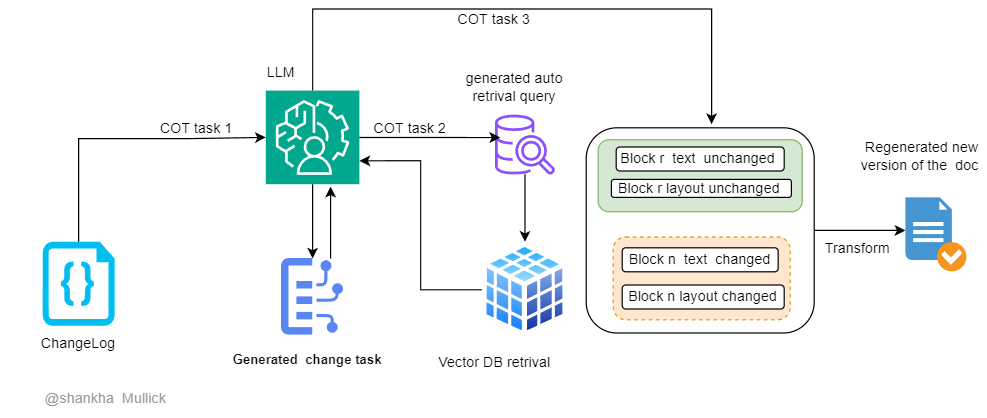





In [9]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

### A sample changelog which mentions

In [10]:
changelog='''[Version 2.1.0] - To Be Released: 2023-12-29
Updated:
[Section 1.6 - Exceptional Items]
a. Added sub-section 1.6.1 - Unforeseen Legal Expenses:
Unforeseen legal expenses that were not part of the regular course of business activities are now explicitly excluded from revenues, costs, and profits unless disclosed in the Group's annual report.
b. Added sub-section 1.6.2 - Extraordinary External Events:
Costs and losses resulting from extraordinary external events, such as natural disasters, pandemics, or geopolitical events, are not considered part of the year's operations unless disclosed separately in the Group's annual report.
General Note:
Any inclusion of items falling under sub-sections 1.6.1 and 1.6.2 for reconciliation purposes requires a comprehensive and transparent explanation in the financial reporting, ensuring stakeholders are informed about the nature and impact of these exceptional items on the company's financial performance.'''


### Defining Chain of Thought Prompt Templates

In [11]:
from langchain.prompts import PromptTemplate

cot_task1_template =PromptTemplate.from_template("""
Step1 :

given the  following changelog for a policy document containing change instruction and change text process and segments (add section /update section / delete section ) ;
Extracts only text sections where Create update delete task are described ; Ignore general statemets;
do not to modify the change details text

changelog  :

"{changelog}"

output requirements:
1.Provide the change segments only create section/ update section/ delete section;
""")

cot_task2_template =PromptTemplate.from_template(""" Given the change task of a document; change task = "{change_task}" ;
your task is to write  a  query string for matching similar document excerpt stored in the Vector database ;
compress the string by removing unnecessary words spaces carriage return and parentheses; keep and focus on section number;
output the query string only ;  """)

cot_task3_template =PromptTemplate.from_template('''Given the a text block from a ofgem compliance document and a change task containing the description of the update .
Create the updated block ;

document_block : "{retrived_document_block}"

change_task : "{change_task}"
updated block should contain the changed section along with unchanged sections;
create the updated block in similar key value format as  the input ;
provide newline characters to prettify and align text;
format output as key value structure like input ;
provide the dictionary only enclsoed within curly braces ;''')

### Defining the pipeline  using Lang Chain expression language

In [20]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import StrOutputParser
from langchain_core.runnables import RunnablePassthrough,RunnableParallel
from langchain_core.runnables import RunnableLambda
from sentence_transformers import SentenceTransformer
from operator import itemgetter
import pinecone

def parse_as_dictionary(_dict):

  print(f"change log and retrived_block : {_dict}")

  return _dict

def semantic_search(search_details) :

  index = pinecone.Index("ofgem-complience")

  user_query = embedding_model_local.encode(search_details).tolist()

  # submit the query to the Pinecone index
  pinecone_answer = index.query(user_query, top_k=1, include_metadata=True)

  return pinecone_answer["matches"][0]['metadata']

# Defined the LLM ;

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

# Chain of thought task 1 chain  : changelog parsing chain

change_task_chain= cot_task1_template | llm | StrOutputParser()

# Chain of thought task 2 chain : Auto Retrival Chain

retriver_chain= cot_task2_template | llm  | StrOutputParser() | RunnableLambda(semantic_search)

# final combined chain to generate the changed / new paragraph block
cot_chain  = (
    {"change_task": change_task_chain}
    |RunnableParallel({"retrived_document_block":retriver_chain , "change_task":RunnablePassthrough()})
    | RunnableLambda(parse_as_dictionary)
    |cot_task3_template
    |llm
    |StrOutputParser()


)

#Execution of the pipeline
changed_block=cot_chain.invoke({"changelog": changelog})

change log and retrived_block : {'retrived_document_block': {'block_name': 'page1_block9', 'block_text': '1.6 Exceptional items: we only expect the revenues, costs and profits to reflect \ncompany activities relating to that year of operations. Examples of financial items we \nwould not expect to be included are, but are not limited to, mark to market \nadjustments, profit or losses on disposal, restructuring costs that have been \nidentified as such in the Group’s annual report and impairment charges. Where the \nRelevant Licensee has included any such items for the purpose of reconciliation, or \notherwise, a clear and full explanation must be provided.  '}, 'change_task': {'change_task': "a. Added sub-section 1.6.1 - Unforeseen Legal Expenses:\nUnforeseen legal expenses that were not part of the regular course of business activities are now explicitly excluded from revenues, costs, and profits unless disclosed in the Group's annual report.\n\nb. Added sub-section 1.6.2 - Extraordina

### Converting LLM output string to python dictionary

In [21]:
changed_block=eval(changed_block)

In [22]:
changed_block

{'block_name': 'page1_block9',
 'block_text': "1.6 Exceptional items: we only expect the revenues, costs and profits to reflect \ncompany activities relating to that year of operations. Examples of financial items we \nwould not expect to be included are, but are not limited to, mark to market \nadjustments, profit or losses on disposal, restructuring costs that have been \nidentified as such in the Group’s annual report and impairment charges. Where the \nRelevant Licensee has included any such items for the purpose of reconciliation, or \notherwise, a clear and full explanation must be provided.\n\n1.6.1 Unforeseen Legal Expenses:\nUnforeseen legal expenses that were not part of the regular course of business activities are now explicitly excluded from revenues, costs, and profits unless disclosed in the Group's annual report.\n\n1.6.2 Extraordinary External Events:\nCosts and losses resulting from extraordinary external events, such as natural disasters, pandemics, or geopolitical e

##Transformation/Doc Recreation
Converting updatedblock wise paragraph text and layout metadata into the new Version of the doc

In [23]:
def update_extracted_block_list(blocks, update_data):
    block_name = update_data['block_name']
    block_text = update_data['block_text']
    # Find the index of the block to be updated
    index_to_update = next((index for index, block in enumerate(blocks) if block['block_number'] == block_name), None)

    if index_to_update is not None:
        # Update the block with new text
        blocks[index_to_update]['block_text'] = block_text
        print(f"Block '{block_name}' has been updated successfully.")
    else:
        print(f"Block '{block_name}' not found.")

    return blocks




In [24]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from anyascii import anyascii
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from textwrap import wrap

def create_pdf1(output_blocks, output_pdf_path):
    c = canvas.Canvas(output_pdf_path, pagesize=letter)

    # Set initial position
    x_position = 100
    y_position = 750

    for block_info in output_blocks:


        # Register the DejaVuSans font
        pdfmetrics.registerFont(TTFont('Vera', 'Vera.ttf'))
        pdfmetrics.registerFont(TTFont('VeraBd', 'VeraBd.ttf'))
        pdfmetrics.registerFont(TTFont('VeraIt', 'VeraIt.ttf'))
        pdfmetrics.registerFont(TTFont('VeraBI', 'VeraBI.ttf'))


        block_text = block_info.get('block_text', '')
        block_formatting = block_info.get('block_formatting', {})

        # Extract formatting information
        font_size = block_formatting.get('size', 12.0)
        font_color = block_formatting.get('color', 0)
        font_face = block_formatting.get('face', 'Vera')  # Use a built-in bold font
        if font_face == 'Verdana,Bold':

          font_face='VeraBd'

        else :

          font_face='Vera'

        # Set formatting for the PDF canvas
        c.setFont(font_face, font_size)
        c.setFillColorRGB(*_get_rgb_values(font_color))

        # Convert escape sequences to Unicode characters
        block_text = anyascii(block_text.encode('unicode_escape').decode('utf-8'))
        #block_text=block_text.replace('\\n\\n','')
        block_text=block_text.replace('\\uf0b7 \\n','\t  ')
#        print(block_text)
        # Replace '\n' with actual line breaks and split the text

        lines = block_text.split('\\n')

        # Calculate the height of the text in each line
        text_height = font_size

        # Draw each line on the PDF canvas
        for line in lines:

           if len(line)>=90:

              line_wraped=wrap(line, 90)

              for spilt_lines in line_wraped:

                c.drawString(x_position, y_position, spilt_lines)
                y_position -= text_height + 8  # Add some spacing between lines

           else:

              c.drawString(x_position, y_position, line)
              y_position -= text_height + 8  # Add some spacing between lines

        if y_position <=120 :
          c.showPage()
          y_position=750

    c.save()

def _get_rgb_values(color):
    # Convert the color value to RGB
    return ((color >> 16) & 0xff) / 255.0, ((color >> 8) & 0xff) / 255.0, (color & 0xff) / 255.0





In [25]:
# Call the update function
updated_blocks_list=update_extracted_block_list(extracted_blocks, changed_block)

# Print the updated list of dictionaries
print(updated_blocks_list)


[{'block_number': 'page1_block1', 'block_text': 'Guidelines ', 'block_formatting': {'size': 12.0, 'color': 0, 'face': 'Verdana,Bold'}}, {'block_number': 'page1_block2', 'block_text': "1.1 These guidelines relate to Standard Condition 19A of the Gas and Electricity \nSupply Licences and Standard Condition 16B of the Electricity Generation Licences \n(collectively referred to as 'the Conditions' for the purposes of these guidelines).  ", 'block_formatting': {'size': 9.960000038146973, 'color': 0, 'face': 'Verdana'}}, {'block_number': 'page1_block3', 'block_text': "1.2. The guidelines have been prepared by the Office of Gas and Electricity Markets \n('Ofgem') pursuant to paragraph 9/19A.9 of the Conditions (throughout this \ndocument the first paragraph number relates to the generation licence and the \nsecond relates to the supply licences).  \n \nScope and Application of the Licence Condition  \n1.3. The Conditions only apply to those companies that are “Relevant Licensees” as \ndefined

In [26]:
output_pdf_path = '/content/css_output_guidelines_v2.pdf'
create_pdf1(updated_blocks_list, output_pdf_path)

#Summarization or analysis of regulatory compliance documents

###A Small to Big Retrieval RAG

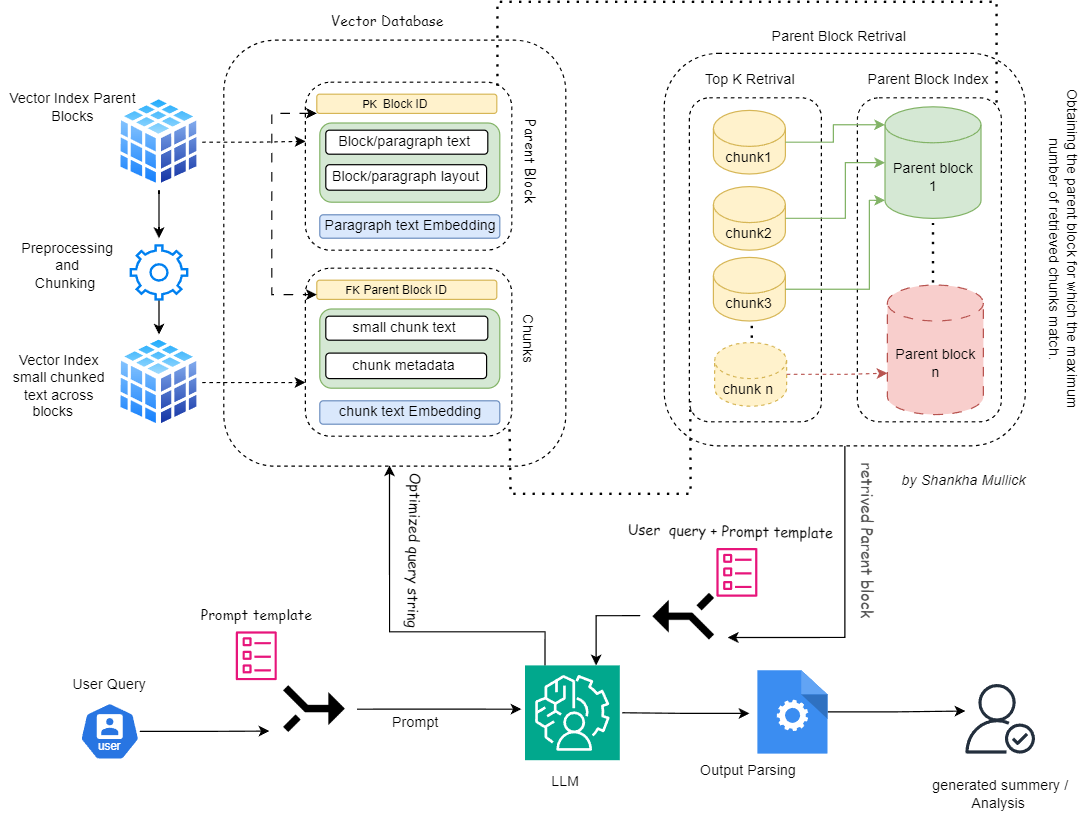